In [1]:
!pip install coremltools

In [4]:
# Initialise packages 
from model import U2NETP
import coremltools as ct
from coremltools.proto import FeatureTypes_pb2 as ft
import torch
import torch.nn as nn   
from torch.autograd import Variable
import os
import numpy as np
from PIL import Image
from torchvision import transforms
from skimage import io, transform

In [7]:
from torchvision import transforms

def save_output(pred, image):
    print(pred.shape)
    predict = pred
    predict = predict.squeeze()
    print(predict.shape)
    predict_np = predict.cpu().data.numpy()
    im = Image.fromarray(predict_np * 255).convert('RGB')
    imo = im.resize((image.size[0],image.size[1]),resample=Image.BILINEAR)
    
    display(imo)

In [10]:
# Pre-processing

def tensor_lab(sample):
    image = sample

    tmpImg = np.zeros((image.shape[0],image.shape[1],3))
    image = image/np.max(image)
    
    tmpImg[:,:,0] = (image[:,:,0]-0.485)/0.229
    tmpImg[:,:,1] = (image[:,:,1]-0.456)/0.224
    tmpImg[:,:,2] = (image[:,:,2]-0.406)/0.225

        # change the r,g,b to b,r,g from [0,255] to [0,1]
    tmpImg = tmpImg.transpose((2, 0, 1))

    return torch.from_numpy(tmpImg)

def input_test_image(image_name):
    inputs_test = Image.open(image_name)
    inputs_test = inputs_test.resize((320, 320))
    inputs_test = np.asarray(inputs_test)
    inputs_test = tensor_lab(inputs_test)
    inputs_test = inputs_test.unsqueeze_(0)
    inputs_test = inputs_test.type(torch.FloatTensor)

    return inputs_test

In [32]:
image_name = "test_data/test_images/0002-01.jpg"
input_image = input_test_image(image_name)
net = U2NETP(3,1)
device = torch.device('cpu')
net.load_state_dict(torch.load("saved_models/u2netp/u2netp.pth", map_location=device))
net.cpu()
net.eval()
d1,d2,d3,d4,d5,d6,d7 = net(input_image)

torch.Size([1, 1, 320, 320])
torch.Size([320, 320])


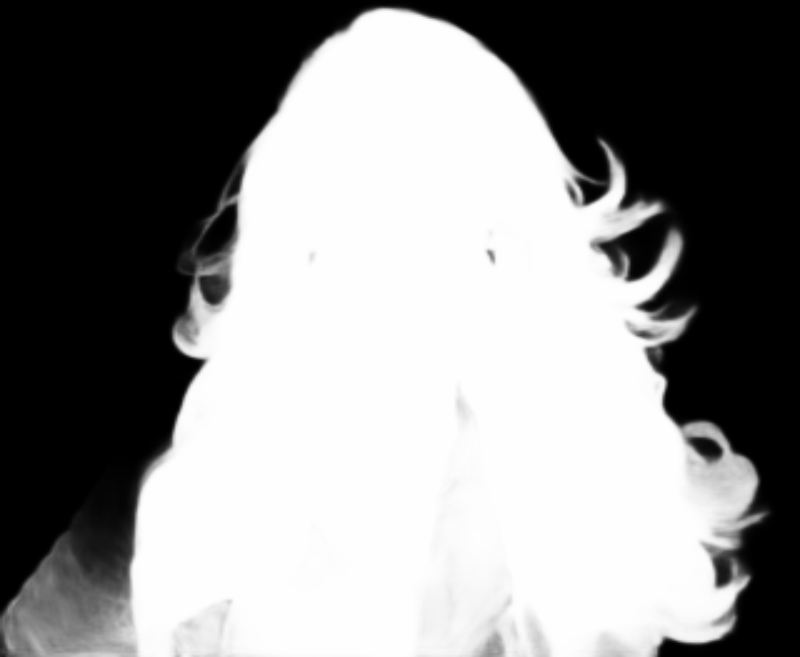

In [33]:
save_output(d1, Image.open(image_name))

In [47]:
# Initialise Baseline UNETP model.
net = U2NETP(3,1)
device = torch.device('cpu')
net.load_state_dict(torch.load("saved_models/u2netp/u2netp.pth", map_location=device))
net.cpu()
net.eval()

U2NETP(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(16, 16, 

In [48]:
# Trace the model.
input_image = input_test_image(image_name)
traced_model = torch.jit.trace(net, input_image)

In [49]:
# Convert the model
_inputs = ct.ImageType(
    name= "input_1", 
    shape= input_image.shape, 
    bias=[-0.456/0.224,
          -0.406/0.225,
          -0.485/0.229],
    scale=1.0/255.0
    )
model = ct.convert(traced_model, inputs=[_inputs])

Translating MIL ==> MLModel Ops: 100%|██████████| 2224/2224 [00:00<00:00, 12881.33 ops/s]


In [50]:
# Add metadata
model.short_description = "U2-Net: Going Deeper with Nested U-Structure for Salient Object Detection"
model.license = "Apache 2.0"
model.author = "Qin, Xuebin and Zhang, Zichen and Huang, Chenyang and Dehghan, Masood and Zaiane, Osmar and Jagersand, Martin"

In [51]:
# Rename inputs
spec = model.get_spec()
ct.utils.rename_feature(spec, "input_1", "in_0")
ct.utils.rename_feature(spec,"2169","out_a0")
ct.utils.rename_feature(spec,"2170","out_a1")
ct.utils.rename_feature(spec,"2171","out_a2")
ct.utils.rename_feature(spec,"2172","out_a3")
ct.utils.rename_feature(spec,"2173","out_a4")
ct.utils.rename_feature(spec,"2174","out_a5")
ct.utils.rename_feature(spec,"2175","out_a6")
model = ct.models.MLModel(spec)
model.save("creating_models/u2netp_temp.mlmodel")

In [52]:
# Re-open model for modification
model = ct.models.MLModel("creating_models/u2netp_temp.mlmodel")

In [53]:
# Get the model specifications
spec = model.get_spec()

In [54]:
# Change model input and save
input = spec.description.input[0]
input.type.imageType.colorSpace = ft.ImageFeatureType.BGR
input.type.imageType.height = 320 
input.type.imageType.width = 320

ct.utils.save_spec(spec, "creating_models/u2netp_temp_new_input.mlmodel")

In [55]:
# Re-open model for modification
model = ct.models.MLModel("creating_models/u2netp_temp_new_input.mlmodel")
spec = model.get_spec()
spec_layers = getattr(spec, spec.WhichOneof("Type")).layers
output_layers = spec_layers[476:] # Get only the last output layers, may change with full-size U^2net

In [57]:
# Append new layers
new_layers = []
layernum = 0;
for layer in output_layers:
    new_layer = spec_layers.add()
    new_layer.name = 'out_p' + str(layernum)
    new_layers.append('out_p' + str(layernum))

    new_layer.activation.linear.alpha = 255
    new_layer.activation.linear.beta = 0

    new_layer.input.append('out_a' + str(layernum))
    new_layer.output.append('out_p' + str(layernum))
    output_description = next(x for x in spec.description.output if x.name==output_layers[layernum].output[0])
    output_description.name = new_layer.name

    layernum = layernum + 1

In [58]:
# Specify the outputs as grayscale images.
for output in spec.description.output: 
    if output.name not in new_layers: 
        continue
    if output.type.WhichOneof('Type') != 'multiArrayType': 
        raise ValueError("%s is not a multiarray type" % output.name) 

    array_shape = tuple(output.type.multiArrayType.shape) 
    # print(array_shape)
    # print(output.type)


    output.type.imageType.colorSpace = ft.ImageFeatureType.ColorSpace.Value('GRAYSCALE')
    output.type.imageType.width = 320 
    output.type.imageType.height = 320

In [59]:
updated_model = ct.models.MLModel(spec)
model.short_description = "U2-Net: Going Deeper with Nested U-Structure for Salient Object Detection"
model.license = "Apache 2.0"
model.author = "Qin, Xuebin and Zhang, Zichen and Huang, Chenyang and Dehghan, Masood and Zaiane, Osmar and Jagersand, Martin"

updated_model.save("updated_model.mlmodel")
